In [8]:
import numpy as np
from helpers.helper import plotC, sample_data
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from helpers.helper import load_kernel_dataset_1
from helpers.plots import plot

%load_ext autoreload
%autoreload 2

import grading.generate_test_and_grading_data as gtgd
import tests.tests as tests

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
build_test_data = True

# Graded Exercise 2

**Date: 06.12.2019**

Welcome to the second graded exercise. In this exercise, you will be tested on the following topics: linear classification, linear SVM, PCA, kernel methods. 

You are asked to fill in the code in a couple of cells throughout the exercise. For each such cell we provided tests which are run along with the cell and save your results to a file. The cells are independent of each other and you will receive points for each individual cell.

If your code passes the tests this is a good sign, but it **does not guarantee** that you will get a full grade for that cell.

Before you finish, please make sure to **upload two files to Moodle**:
* **graded_exercise_2.ipynb**
* **answers_SCIPER.npz (e.g. "answers_280595.npz")**

Good luck! :-)

#### Important: Enter your SCIPER number below and run the cell

In [10]:
sciper_number = 123456  # e.g. 123456

## Part 1: Logistic Regression

We are dealing with multiclass logistic regression with $K$ classes. We have trained a model and found a set of model weights $\mathbf{W} \in \mathbb{R}^{D \times K}$, i.e. the weights for all $K$ binary classifiers are stored in columns of $\mathbf{W}$ so that the weights of the classifier predicting the class with label $0$ are in the 1st column, weights of the classifier predicting the class with label $1$ are in the second column and so on. 

Given the test dataset $X \in \mathbb{R}^{N \times D}$, for every sample we would like to find the class labels $y \in \{0, 1, ..., K-1\}$ of the $k$ classes with the highest probability as predicted by our model. This is a strategy commonly used in popular classification challenges (such as ImageNet Large Scale Visual Recognition Challenge), where we do not only report our best guess for a given test sample, but also our $k$ best guesses.

First fill in the function `find_probabilities` which takes as input test dataset $X$ and model weights $\mathbf{W}$, and returns an array of shape $(N \times K)$ as the probabilities of datasamples belonging to each class.

Then, fill in the function `top_k` which takes the class probabilities and a number $k$ and returns the labels of $k$ classes with the highest predicted probabilities. The labels must be sorted from the highest to the lowest probability for every data sample. Hint: Recall that you can sort the values and indices of an array using `np.sort` and `np.argsort`.

In [11]:
def find_probabilities(X, W):
    """ Given the model represented by the set of weights `W` and the 
    dataset `X`, this function predicts the probability distribution 
    of every sample in `X` belonging to a class k.
    
    Args:
        X (np.array): Test dataset, shape (N, D).
        W (np.array): Model weights, shape (D, K).
        
    Returns:
        probabilities (np.array of float): Probabilities, shape (N, K).
    """
    ### YOUR CODE HERE ###
    XW = X @ W
    probabilities = np.exp(XW) / np.sum(np.exp(XW), axis=1, keepdims=True)  # (N, K)
    return probabilities
    ######################

if build_test_data:
     gtgd.generate_find_probabilities_data(locals())
probabilities = tests.test_find_probabilities(locals())

[test_find_probabilities] No problems detected. Your code is correct! 😎


In [12]:
def top_k(probabilities, k):
    """ Given the per-sample probability distribution over labels `probabilities`,
    this function selects the `k` highest probability labels for every sample
    and returns them in a sorted way.
    
    Args:
        probabilities (np.array): Per-sample probability distribution over labels, 
            shape (N, K), K is number of classes.
        k (int): Number of highest probability classes to return, k < K.
        
    Returns:
        labels (np.array of int): Predicted classes labels sorted by decreasing 
            probability, shape (N, k).
    """
    ### YOUR CODE HERE ###
    labels = np.argsort(probabilities, axis=1)[:, ::-1][:, :k]
    return labels
    ######################
    

if build_test_data:
     gtgd.generate_top_k_data(locals())
probabilities = tests.test_top_k(locals())

[test_top_k] No problems detected. Your code is correct! 😎


## Part 2: SVM

### 2.1 Count the number of support vectors

Note that the decision_function we defined in the function is result of $\tilde{\mathbf{w}}^T\mathbf{x} + w_0$.

In [13]:
# 1. Count the number of support vectors
def count_support_vectors(decision_function, y):
    """ Given the decision function and labels, output the number of support vectors in 
    the input dataset.
    
    Args:
        decision_function (np.array): shape (N,), results of wx+w0
        y (np.array): shape (N,), binary labels with {-1,1}
    
    Returns:
        count (int): Number of support vectors.
    """
    ### CODE HERE ###
    support_vector_indices = np.where(y * decision_function <= 1.00)[0]   
    count = len(support_vector_indices)
    
    return count

if build_test_data:
    gtgd.generate_count_support_vectors_data(locals())
    
tests.test_count_support_vectors(locals())

 Saving TEST and GRADING data for count_support_vectors
[test_count_support_vectors] No problems detected. Your code is correct! 😎


### 2.2 Compute the primal coefficients

Note that the dual coefficients used here are the real ones(that is $\alpha_i$ in the slides), not the direct outputs from the fitted model in sklearn.svm.SVC.

In [14]:
# 2. Compute the primal coefficients

def compute_primal_coef(dual_coef, labels, support_vectors):
    '''
    given real dual coefficients, labels and support_vectors, compute the primal coefficients
    
    input:
    dual_coef: true dual coefficients, np.array of shape (1, n) where n is the number of support vectors.
    labels: np.array of shape (1, n) where n is the number of support vectors, the value is either -1 or 1.
    support_vectors: np.array of shape (n, D) where n is the number of support vectors and D is the dimension of features.
    
    output:
    primal_coef: primal coefficients, np.array of shape (D, )
    '''
    ## CODE HERE
    primal_coef = np.sum((dual_coef*labels).T * support_vectors, axis=0)
    
    return primal_coef

if build_test_data:
    gtgd.generate_compute_primal_coef_data(locals())
tests.test_compute_primal_coef(locals())

 Saving TEST and GRADING data for compute_primal_coef
[test_compute_primal_coef] No problems detected. Your code is correct! 😎


### 2.3 Choose the the approperiate kernel

We mainly learn 2 different widely used kernels, they are Polynomial Kernel ('P') and RBF kernels ('R'). 

Now given a dataset, please compare the models with different kernels and parameters, then choose the approperiate kernel for it.

***Question***: Run the 3 cells below to see the visualization of the dataset and classification result using RBF and Polynomial kernels. Looking at the plots, which kernel would you expect to fit the testing data better, given the assumption that testing data holds the same distribution as the training one? (Please choose 'R' or 'P'.) Note that P means Polynomial Kernel and R means RBF kernels.

In [15]:
### ANSWER HERE
answer = 'p' 
tests.test_choose_kernel(locals(), answer)

Format is correct.😎


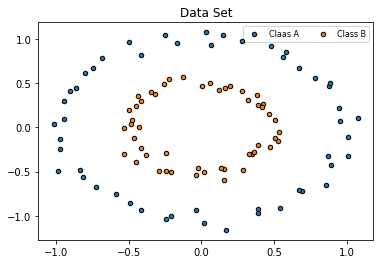

In [16]:
# Load Dataset and visualize it
X_1,y_1 = load_kernel_dataset_1()
plot(X_1,y_1,None,dataOnly=True)

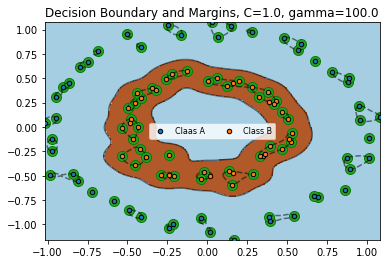

In [17]:
# Declare a RBF SVM classifier with C=1.0 and gamma=100.0

clf_RBF = SVC(kernel = 'rbf', C=1.0, gamma=100.0)

## fit the dataset
clf_RBF.fit(X_1, y_1)
plot(X_1, y_1, clf_RBF)

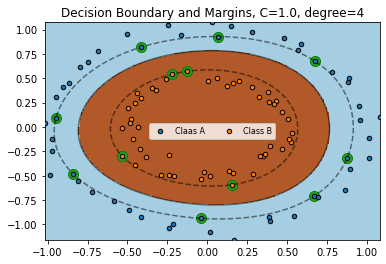

In [18]:
# Declare a Polynomial SVM classifier with  C=1.0, degree=4, gamma=1.0, coef0=1.0 

clf_poly = SVC(kernel='poly', C=1.0, degree=4, gamma=1.0, coef0=1.0)

## fit the dataset
clf_poly.fit(X_1, y_1)
plot(X_1, y_1, clf_poly)

## Part 3: LDA

###  Compute Scatter Matrix for LDA
In the lecture, you have seen the LDA method. We ask you to implement the two matrices i.e. within-class scatter matrix $\mathbf{S_w}$ and between-class scatter matrix $\mathbf{S_b}$, for the given data matrix $\mathbf{X}$ . In order to compute them we also need data mean $\bar{\mathbf{x}}$ and class-wise mean $\mathbf{\mu}_c$, which you will implement in the following functions.

In [19]:
'''
Compute the data mean
Input:
    X: data matrix of shape NxD
Output:
    x_bar: mean of entire data of shape (1,D)
'''
def lda_mat_data_mean(X):
    ## CODE HERE
    # data mean. Make sure you have proper dimensions of array.
    x_bar = X.mean(axis=0,keepdims=True)
    return x_bar

if build_test_data:
    gtgd.generate_lda_mat_data_mean(locals())
tests.test_lda_mat_data_mean(locals())

 Saving TEST and GRADING data for lda data mean exercise
[test_lda_mat_data_mean] No problems detected. Your code is correct! 😎


In [20]:
'''
Compute the classwise mean
Input:
    X: data matrix of shape NxD
    labels: ground truth class label of shape (N,)
    num_classes: number of classes in the dataset
Output:
    mu_c: list of length num_classes with each element of shape (1,D) array
          representing per class mean
'''
def lda_mat_clswise_mean(X,labels,num_classes):
    ## CODE HERE
    # class wise mean. Make sure you have proper dimensions of arrays.
    mu_c = []
    for i in range(num_classes):
        mu_c.append(X[labels == i,:].mean(axis=0,keepdims=True))
    return mu_c

if build_test_data:
    gtgd.generate_lda_mat_clswise_mean(locals())
tests.test_lda_mat_clswise_mean(locals())

 Saving TEST and GRADING data for lda clswise mean exercise
[test_lda_mat_clswise_mean] No problems detected. Your code is correct! 😎


In [21]:
'''
Compute S_w and S_b
Input:
    X: data matrix of shape NxD
    labels: ground truth class label of shape (N,)
    num_classes: number of classes in the dataset
    x_bar: mean of entire data of shape (1,D)
    mu_c: list of length num_classes with each element of shape (1,D) array
          representing per class mean
Output:
    S_w: within-class scatter matrix of shape (D,D)
    S_b: between-class scatter matrix of shape (D,D)
'''
def lda_mat(X,labels,num_classes,x_bar,mu_c):
    
    ## CODE HERE
    # S_w
    S_w = np.zeros((X.shape[1],X.shape[1]))
    for i in range(num_classes):
        x_c = X[labels == i,:]
        centered_x_c = x_c - mu_c[i]
        S_w += centered_x_c.T@centered_x_c

    ## CODE HERE
    # S_b 
    S_b = np.zeros((X.shape[1],X.shape[1]))
    for i in range(num_classes):
        N_c = X[labels==i,:].shape[0]
        S_b += N_c*(mu_c[i] - x_bar).T@(mu_c[i] - x_bar)

    return S_w, S_b

# if build_test_data:
#     gtgd.generate_lda_mat_data(locals())
tests.test_lda_mat(locals())

[test_lda_mat] No problems detected. Your code is correct! 😎


# Part 4 Kernel Ridge Regression

We are dealing with a kernel ridge regression problem and we are given a training dataset $X \in \mathbb{R}^{N \times D}$. We chose to use a polynomial kernel of degree $3$ and we already computed a kernel matrix $K$.

Now we would like to extend our training dataset $X$ by a new **training** sample $x_{\text{new}} \in \mathbb{R}^{D}$. Fill in the function `update_kernel_matrix()` which takes as input the original training dataset $X$, the kernel matrix $K$ precomputed for the training dataset $X$ a new training sample $x_{\text{new}}$ and returns a new kernel matrix $K_{\text{new}}$.

Below we provide the implementations of polynomial kernel of degree 3.

In [22]:
def kernel_polynomial3(xi, xj):
    """ Computes the polynomial of degree 3 kernel function for the
    input vectors `xi`, `xj`.

    Args:
        xi (np.array): Input vector, shape (D, ).
        xj (np.array): Input vector, shape (D, ).

    Returns:
        float: Result of the kernel function.
    """
    return (xi @ xj + 1) ** 3

In [23]:
def update_kernel_matrix(K, X, x_new):
    """ Updates the kernel matrix `K` given the original
    dataset `X` and a new sample `x_new`. Uses kernel function
    `kernel_polynomial3`.
    
    Args:
        K (np.array): Kernel matrix.
        X (np.array): Original dataset (individual data samples in rows).
        x_new (np.array): New data sample.
        
    Returns:
        K_new (np.array): Updated kernel matrix
    """
    ### YOUR CODE HERE ###
    K_new = np.zeros(np.array(K.shape) + 1)
    K_new[:-1, :-1] = K
    for i in range(K.shape[0]):
        K_new[-1, i] = kernel_polynomial3(X[i], x_new)
    K_new[:, -1] = K_new[-1, :]
    K_new[-1, -1] = kernel_polynomial3(x_new, x_new)
    ######################
    
    return K_new

if build_test_data:
     gtgd.generate_kernel_matrix_data(locals())
tests.test_kernel_matrix(locals())

[test_kernel_matrix] No problems detected. Your code is correct! 😎
